## Import All The Libraries 

In [89]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from teaspoon.ML import feature_functions as Ff
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Scaler
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from gtda.images import Binarizer
from gtda.homology import CubicalPersistence
from gtda.images import RadialFiltration
from sklearn.metrics import accuracy_score

## Split The Dataset Into Training Set And Test Set

In [148]:
n_samples = 1000 # number of loaded MNIST handwritten digits

n_features = 32 # number of features per image
image_size = 28 # MNIST handwritten digits images are 28x28
data_X = np.load('X_' + str(n_samples) + '.npy', allow_pickle=True)
data_y = np.load('y_'  + str(n_samples) + '.npy', allow_pickle=True)

from sklearn.model_selection import train_test_split
train_size, test_size = 250, 60


y = data_y
X = data_X.reshape((-1, 28, 28))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (250, 28, 28), y_train shape: (250,)
X_test shape: (60, 28, 28), y_test shape: (60,)


## Create Function To Get More Features

In [149]:
def get_features(transformer, metrix, X, carlsoon_func):
    
    transformed = transformer.fit_transform(X)
    scaler = Scaler()
    transformed = scaler.fit_transform(transformed)

    # Persistence entropy
    persistence_entropy = PersistenceEntropy(normalize=False)
    # calculate topological feature matrix
    X_features = persistence_entropy.fit_transform(transformed)

    # Carlsoon Coordinates

    Arr = transformed[1]
    a1=Arr[Arr[:,2]==0].shape[0]
    a2=Arr[Arr[:,2]==1].shape[0]
    Arr_dim_0 = transformed[:,0:a1,0:2]
    Arr_dim_1 = transformed[:,a1:a1+a2,0:2]
    
    FN = 5
    my_list = [Arr_dim_0, Arr_dim_1]

    # compute feature matrix
    for i in range(0,2):
        FeatureMatrix, TotalNumComb, CombList = Ff.F_CCoordinates(my_list[i], FN)
        X_features = np.concatenate((X_features, FeatureMatrix[carlsoon_func]),axis=1)

    amplitude = Amplitude(**metrix)
    X_features = np.concatenate([X_features, amplitude.fit_transform(transformed)], axis=1)

    return X_features

In [150]:
def get_features_for_different_values(direction_list, center_list, metric_list, X, carlsoon_func=-1):

    radial_filtration = lambda r: Pipeline([
        ("binarizer", Binarizer(threshold=0.4, n_jobs=-1)),
        ("filtration", RadialFiltration(center=np.array(r), n_jobs=-1)),
        ("diagram", CubicalPersistence(n_jobs=-1)),
    ])

    height_filtration = lambda d: Pipeline([
        ("binarizer", Binarizer(threshold=0.4, n_jobs=-1)),
        ("filtration", HeightFiltration(direction=np.array(d), n_jobs=-1)),
        ("diagram", CubicalPersistence(n_jobs=-1)),
    ])

    results_1 = []
    for direction, metrix in zip(direction_list, metric_list):
        transformer = height_filtration(direction)
        X_features = get_features(transformer, metrix, X, carlsoon_func)
        results_1.append(X_features)

    results_2 = []
    for radius in center_list:
        transformer = radial_filtration(radius)
        X_features = get_features(transformer, metrix, X, carlsoon_func)
        results_2.append(X_features)

        

    results_1 = np.concatenate(results_1, axis=1)
    results_2 = np.concatenate(results_2, axis=1)

    return np.concatenate([results_1, results_2], axis=1)

In [151]:
# direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]
direction_list = [[1, 1], [-1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [0, 0],
    [20, 0],
    [0, 20]
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

## Create Features

In [152]:
# Transform the images into features

X_train_tda = get_features_for_different_values(direction_list, center_list, metric_list, X_train)
X_test_tda = get_features_for_different_values(direction_list, center_list, metric_list, X_test)

## Save the dataset

In [160]:
# Save the data to a pickle file
with open('X_train_tda.pkl', 'wb') as f, \
    open('X_test_tda.pkl', 'wb') as f1:
        pickle.dump(X_train_tda, f)
        pickle.dump(X_test_tda, f1)

with open('y_train.pkl', 'wb') as f, \
    open('y_test.pkl', 'wb') as f1:
        pickle.dump(y_train, f)
        pickle.dump(y_test, f1)

print("Data saved successfully.")

Data saved successfully.


In [154]:
# Shape of the X_train

X_train_tda.shape

(250, 182)

In [155]:
# Shape of the X_train

X_test_tda.shape

(60, 182)

## Create RandomForestClassifier

In [156]:
rf = RandomForestClassifier(random_state=12)
rf.fit(X_train_tda, y_train)

# Predict the labels for the test set
y_pred = rf.predict(X_test_tda)

## Evaluate The Accuracy

In [157]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.93


## Display The Confusion Matrix

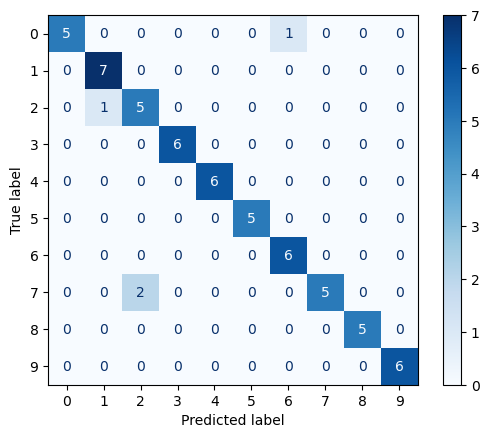

In [158]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Get the class labels from the model
class_labels = rf.classes_  

# Display the confusion matrix with labels
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues')

#### Summary:

- We can see that `2` and `7` are the most confused because of its topology.